## 뉴스 기사 태그 분류
- 뉴스 기사의 태그를 분류하는 커스텀 모델

In [1]:
from torch import nn

[1] 모듈로딩 및 데이터셋 불러오기

In [2]:
import pandas as pd
import os

In [3]:
import re
# 정규식을 사용하는 함수
def re_text(text):

    text = re.sub(r'[^\w가-힇\s]', '', text)  # 한글, 영문자, 숫자 및 공백만 남기고 나머지는 제거
    text = re.sub(r'\b[a-zA-Z]\b', '', text)  # 성능이 너무 안나와서 한글자 영어 제거
    text = re.sub(r'\d+', '', text)  # 성능이 너무 안나와서 숫자 제거
    text = re.sub(r'[\u4E00-\u9FFF]', '', text)   # 한자를 제거
    text = re.sub(r'\s+', ' ', text)  # 여러개 공백을 하나의 공백으로 변환
    return text.strip()  # 앞뒤 공백제거

In [4]:
FILE_DIR = '../../../LocalData/NLP_DATA/NLP_Text_Dataset/'

In [5]:
texts = []
labels = []

for label in range(8):
    label_folder = os.path.join(FILE_DIR, str(label))
    for filename in os.listdir(label_folder):
        file_path = os.path.join(label_folder, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

            clean_text = re_text(text)
            texts.append(clean_text)
            labels.append(label)

In [6]:
df = pd.DataFrame({'text': texts, 'label': labels})

In [7]:
# train, test 나누기
train = df.sample(frac=0.9, random_state=42) # 랜덤으로 90를 선택
test = df.drop(train.index)                  # 트레인을 삭제해서 비율을 train : test = 9: 1

print(train.head(5))
print('Training Data Size : ', len(train))
print("Testing Data Size : ", len(test))

                                                  text  label
526  필리핀 기초단체 선거 후보 명 피살교민 안전주의보 발령 하노이연합뉴스 민영규 특파원...      2
354  주택담보대출 금리 달 만에 또 돌파시장금리 상승 영향 국채금리 상승에 국내 금융채 ...      1
168  단독 MB 국정원 권양숙 여사 미행에 감시까지 뉴스데스크 앵커 고 노무현 전 대통령...      0
135  유승민 안철수 계파갈등바른미래당 내분 격화 공천 탓에 당 쪼개질 판실망한 일부 의원...      0
937  두개골 골절로 뇌사안락사 하루 전 깨어난 세 소년 두 달 전 트레일러 사고로 뇌사 ...      4
Training Data Size :  1440
Testing Data Size :  160


[2] 데이터 전처리

In [8]:
# 데이터 토큰화 및 단어 사전 구축
from konlpy.tag import Okt
from collections import Counter

## 단어사전을 만드는 함수
def build_vocab(corpus, n_vocab, special_tokens): #n_vocab은 최대 사용할 단어개수
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab): # 가장 많이 등장한 순서대로 상위 n_vocab개의 단어 반환
        vocab.append(token)
    return vocab



In [9]:
## 불용어 리스트 불러오는 함수
STOP_PATH = 'kor_stopwords.txt'

def make_stopwords(STOP_PATH):
    with open(STOP_PATH, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines() # 문장단위로
    return set(stopwords)        # 구글드라이브에 있는 모든 사람들의 불용어리스트를 가져와서 한파일에 다넣었기 때문에 혹시모를 중복제거

In [10]:
stopwords = make_stopwords(STOP_PATH)

In [11]:
stopwords

{'ㅈ',
 '가',
 '가까스로',
 '가라',
 '가령',
 '각',
 '각각',
 '각자',
 '각종',
 '감',
 '갔나',
 '갖고말하자면',
 '같다',
 '같이',
 '개',
 '개의치않고',
 '거니와',
 '거바',
 '거의',
 '걸',
 '것',
 '것과 같이',
 '것들',
 '게',
 '게다가',
 '게우다',
 '겨우',
 '견지에서',
 '결과에 이르다',
 '결국',
 '결론을 낼 수 있다',
 '겸사겸사',
 '고',
 '고려하면',
 '고로',
 '곧',
 '곳',
 '공동으로',
 '과',
 '과연',
 '관계가 있다',
 '관계없이',
 '관련이 있다',
 '관하여',
 '관한',
 '관해서는',
 '구',
 '구체적으로',
 '구토하다',
 '그',
 '그들',
 '그때',
 '그래',
 '그래도',
 '그래서',
 '그러나',
 '그러니',
 '그러니까',
 '그러면',
 '그러므로',
 '그러한즉',
 '그런',
 '그런 까닭에',
 '그런데',
 '그런즉',
 '그럼',
 '그럼에도 불구하고',
 '그렇게 함으로써',
 '그렇지',
 '그렇지 않다면',
 '그렇지 않으면',
 '그렇지만',
 '그렇지않으면',
 '그리고',
 '그리하여',
 '그만이다',
 '그에 따르는',
 '그위에',
 '그저',
 '그중에서',
 '그치지 않다',
 '근거로',
 '근거하여',
 '기대여',
 '기점으로',
 '기준으로',
 '기타',
 '까닭으로',
 '까악',
 '까요',
 '까지',
 '까지 미치다',
 '까지도',
 '꽈당',
 '끙끙',
 '끼익',
 '나',
 '나머지는',
 '나왔는데',
 '남들',
 '남짓',
 '내',
 '냐',
 '너',
 '너희',
 '너희들',
 '네',
 '넷',
 '년',
 '논하지 않다',
 '놀라다',
 '누가 알겠는가',
 '누구',
 '는',
 '니',
 '다',
 '다른',
 '다른 방면으로',
 '다만',
 '다섯',
 '다소',
 '다수',
 '다시 말하자면',
 '다시말하

In [12]:
tokenizer = Okt()
train_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords ] for review in train.text]   # 형태소 단위로 나눠서 리스트에 저장
test_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords] for review in test.text]

vocab = build_vocab(corpus=train_tokens, n_vocab=6000, special_tokens=["<pad>", "<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for idx, token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '할', '전', '기자', '한국', '명', '씨', '서울', '지난']
6002


In [13]:
vocab

['<pad>',
 '<unk>',
 '할',
 '전',
 '기자',
 '한국',
 '명',
 '씨',
 '서울',
 '지난',
 '위',
 '됐다',
 '날',
 '북한',
 '시',
 '미국',
 '한다',
 '밝혔다',
 '대한',
 '성',
 '지',
 '원',
 '안',
 '못',
 '때문',
 '통해',
 '사람',
 '장',
 '관련',
 '대통령',
 '서',
 '중국',
 '경찰',
 '더',
 '이후',
 '정부',
 '같은',
 '대표',
 '에서는',
 '사실',
 '문제',
 '보다',
 '있다고',
 '조사',
 '김',
 '경우',
 '지난해',
 '관계자',
 '뒤',
 '했다고',
 '혐의',
 '이어',
 '상황',
 '되는',
 'A',
 '세',
 '후보',
 '대회',
 '점',
 '최근',
 '따르면',
 '연',
 '의원',
 '주',
 '후',
 '진행',
 '에도',
 '달',
 '현재',
 '하기',
 '입니다',
 '라고',
 '확인',
 '시장',
 '기',
 '상',
 '간',
 '하며',
 '예정',
 '해야',
 '설명',
 '하면',
 '주장',
 '조',
 '팀',
 '시작',
 '결과',
 '세계',
 '뉴스',
 '이나',
 '지역',
 '오후',
 '한다고',
 '경기',
 '회담',
 '정도',
 '입장',
 '생각',
 '차',
 '있다는',
 '가격',
 '트럼프',
 '큰',
 '모습',
 '데',
 '사건',
 '정상회담',
 '방송',
 '게임',
 '국내',
 '당시',
 '공개',
 '건',
 '가장',
 '라며',
 '수사',
 '측',
 '이라는',
 '약',
 '북미',
 '일본',
 '특히',
 '연합뉴스',
 '가능성',
 '없는',
 '현',
 '단',
 '계획',
 '발생',
 '권',
 '되고',
 '회장',
 '이유',
 '올해',
 '이용',
 '상태',
 '잘',
 '공',
 'LG',
 '검찰',
 '사용',
 '킹',
 '총',
 '국회',
 '앞',
 '과정

In [14]:
## 패딩을 위한 문장길이 히스토그램
import matplotlib.pyplot as plt

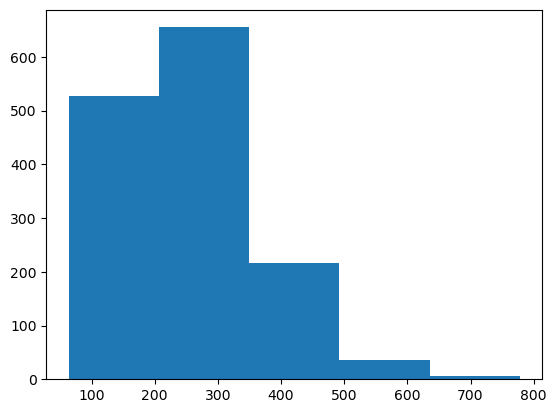

In [15]:
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen, bins=5)
plt.show()

In [16]:
# 못걸러진 불용어 찾기
all_tokens = [token for tokens in train_tokens for token in tokens]
token_counts = Counter(all_tokens)
frequencies = list(token_counts.values())

token_counts.most_common(40)

[('할', 2000),
 ('전', 1431),
 ('기자', 1157),
 ('한국', 1061),
 ('명', 990),
 ('씨', 978),
 ('서울', 973),
 ('지난', 902),
 ('위', 886),
 ('됐다', 788),
 ('날', 775),
 ('북한', 769),
 ('시', 733),
 ('미국', 728),
 ('한다', 724),
 ('밝혔다', 723),
 ('대한', 710),
 ('성', 700),
 ('지', 665),
 ('원', 635),
 ('안', 634),
 ('못', 631),
 ('때문', 628),
 ('통해', 627),
 ('사람', 610),
 ('장', 603),
 ('관련', 597),
 ('대통령', 596),
 ('서', 596),
 ('중국', 594),
 ('경찰', 589),
 ('더', 589),
 ('이후', 559),
 ('정부', 559),
 ('같은', 550),
 ('대표', 525),
 ('에서는', 522),
 ('사실', 516),
 ('문제', 515),
 ('보다', 506)]

max length는 500이 가장 이상적일수는 있으나 시간상 400

In [17]:
## 정수 인코딩 및 패딩
import numpy as np
# 패딩까지 해주는 함수
def pad_sequences(sequences, max_length, pad_value):  #입력받는 sequences는 리스트형태
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length] # 시퀀스가 max_lenth보다 길경우 뒷부분을 자른다
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length   # 시퀀스가 짧을경우 남은부분을 0으로 채움
        result.append(padded_sequence)
    return np.asarray(result)

In [18]:
unk_id = token_to_id["<unk>"]   # 단어사전에 없는 단어를 처리할때
train_ids = [[token_to_id.get(token, unk_id) for token in review] for review in train_tokens]  # 각 토큰에 대응하는 정수 ID반환, 존재하지않으면 unk
test_ids = [[token_to_id.get(token, unk_id) for token in review] for review in test_tokens]

max_length = 400
pad_id = token_to_id["<pad>"]   # <pad>": 0, "<unk>": 인 사전이니까 0으로 패딩을 한다는 의미
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

# 결과로 모두 32에 맞춰져서 나온다

[1232 2456  266  310   56    6    1    1  439 3663 4887    1  122    1
  950 1232 2456    1  266    1   37   62    1  310 2994  144 4888  221
 3664   56    6  873   63 1232    5 1795  757    1  439 3663 4887   63
 1232    5 1795  757 1440  154 1603    9    9 1232 3247    1   56    6
    1 3109   17  182 1323   78    1  310 3499  155    1 3874   76 2554
  645 5229 2864 4083    1  310  739  740 1292   24 3355    1   78 3248
 3875 1369 3876   29 1574  470 1198  132  794  344    5 1795    1    1
    1 5626    1    1  620  535 2457  439 5627 2995 1836 1348    5 1795
  310  313 1604    1 1097    1    1  608    1  983 5230   28    1    1
    1    1 1717 1836   22    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

[3] 모델 학습 준비

In [19]:
## 데이터로더
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.label.values, dtype=torch.long)
test_labels = torch.tensor(test.label.values, dtype=torch.long)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [20]:
for feature, label in train_loader:
    print(feature)
    print(label)
    break

tensor([[ 393,   21,  708,  ...,  490,  560,   37],
        [   1,  598,    1,  ...,    0,    0,    0],
        [   8,  323,  325,  ...,    0,    0,    0],
        ...,
        [1614, 5256, 5397,  ...,    0,    0,    0],
        [   1,   89,    1,  ...,    0,    0,    0],
        [2951, 1521, 1168,  ...,    0,    0,    0]], dtype=torch.int32)
tensor([0, 5, 1, 3, 3, 3, 6, 2, 7, 6, 0, 6, 4, 5, 6, 3])


In [21]:
# 다중 분류 모델
class SentenceClassifier(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers, n_classes, dropout=0.5, bidirectional=True, model_type="lstm"):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim, padding_idx=0)

        if model_type == 'rnn':
            self.model = nn.RNN(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )
        elif model_type == 'lstm':
            self.model = nn.LSTM(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )

        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, n_classes)
        else:
            self.classifier = nn.Linear(hidden_dim, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [22]:
## 손실 함수와 최적화 함수 정의
from torch import optim

n_vocab = len(token_to_id)   # 단어사전의 크기
hidden_dim = 64     # 은닉 사태의 크기
embedding_dim = 128   #임베딩 벡터의 차원 128차원으로 사용
n_layers = 2     # 2층
n_classes = 8 # 다중분류

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers, n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)   #
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)

[4] 모델 학습

In [23]:
# 모델 학습하는 함수
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%interval == 0:
            print(f'Train Loss {step} : {np.mean(losses)}')

In [24]:
# 모델 테스트하는 함수
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):   #step은 미니 배치의순서, (inout_ids, labels) 배치단위의 데이터
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        logits = model(input_ids)   #예측값
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.argmax(logits, dim=1)
        corrects.extend((yhat == labels).cpu().tolist())        #예측값과 실제값이 같은지비교

    print(f"Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}")


In [ ]:
epochs =10
interval = 500   #500번 미니배치마다 손실출력

for epoch in range(epochs):
    train(classifier, train_loader, criterion, optimizer, device, interval)
    test(classifier, test_loader, criterion, device)

Train Loss 0 : 2.0515453815460205
Val Loss : 2.0549415230751036, Val Accuracy : 0.11875
Train Loss 0 : 2.132779836654663
Val Loss : 2.071548044681549, Val Accuracy : 0.125
Train Loss 0 : 2.1503310203552246
Val Loss : 2.0636583089828493, Val Accuracy : 0.16875
Train Loss 0 : 2.0677318572998047
Val Loss : 2.042416977882385, Val Accuracy : 0.11875
Train Loss 0 : 1.7721232175827026
Val Loss : 2.0462789654731752, Val Accuracy : 0.15625
Train Loss 0 : 2.0661654472351074
Val Loss : 2.033605659008026, Val Accuracy : 0.16875
Train Loss 0 : 2.015780210494995
Val Loss : 2.0564221501350404, Val Accuracy : 0.1375
Train Loss 0 : 1.9260164499282837
Val Loss : 2.0545559883117677, Val Accuracy : 0.15
Train Loss 0 : 1.6496217250823975
Val Loss : 2.084647738933563, Val Accuracy : 0.14375
Train Loss 0 : 2.0580055713653564
Val Loss : 2.0781605720520018, Val Accuracy : 0.1625


커스텀 모델은  한계.. 다음번엔 전이학습이용해야할듯

시간상 여기까지..